In [ ]:
# Import necesary packages
import pandas as pd
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager 
import time
import random
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_rel
import statsmodels.api as sm
from scipy.stats import shapiro
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# read in csv file named company_ipo.csv
company_ipo = pd.read_csv("company_ipo.csv", encoding="utf-8", sep=",")

# Display results to test
display(company_ipo)

In [ ]:
# Setup Chrome
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 30)

# Set the years to scrape (only 2019-2020 for data volume issues)
years = [2019, 2020]
all_data = []

# Loop through years
for year in years:
    url = f"https://stockanalysis.com/ipos/{year}/"
    driver.get(url)
    print(f"\nLoaded IPO page for {year}")
    time.sleep(random.uniform(1.5, 3))

    # Go through elements on webpage to locate and enable market cap on each page
    try:
        wait.until(EC.presence_of_element_located((By.TAG_NAME, "table")))
        print("Table element found")

        # Click the "Indicators" button
        indicators_btn = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[.//span[text()="Indicators"]]')))
        driver.execute_script("arguments[0].scrollIntoView(true);", indicators_btn)
        driver.execute_script("arguments[0].click();", indicators_btn)
        print("Clicked 'Indicators'")

        # Check 'Market Cap' button
        checkbox = wait.until(EC.presence_of_element_located((By.XPATH, '//label[contains(text(), "Market Cap")]/preceding-sibling::input')))
        if not checkbox.is_selected():
            checkbox.click()
            print("Checked 'Market Cap'")
            time.sleep(1.5)

        # Click outside to close dropdown menue, so you can scrape it
        body = driver.find_element(By.TAG_NAME, "body")
        driver.execute_script("arguments[0].click();", body)
        print("Closed dropdown")
        time.sleep(1.5)

        # Wait a second and scrape table
        try:
            table = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table#main-table")))
            rows = table.find_elements(By.TAG_NAME, "tr")
            headers = [cell.text.strip() for cell in rows[0].find_elements(By.TAG_NAME, "th")]

            print(f"Columns found for {year}: {headers}")

            for row in rows[1:]:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) == len(headers):
                    row_data = {headers[i]: cells[i].text.strip() for i in range(len(headers))}
                    row_data["Year"] = year
                    all_data.append(row_data)

        except Exception as e:
            print(f"Failed to read table for {year}: {e}")
            driver.save_screenshot(f"ipo_debug_{year}.png")
            with open(f"ipo_page_source_{year}.html", "w", encoding="utf-8") as f:
                f.write(driver.page_source)
            continue

    except Exception as e:
        print(f"General scraping error for {year}: {e}")
        driver.save_screenshot(f"ipo_debug_{year}_main.png")
        with open(f"ipo_page_source_{year}_main.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        continue

driver.quit()

# Create DataFrame
ipo_df = pd.DataFrame(all_data)
ipo_df.columns = ipo_df.columns.str.strip()

# Output preview
print("\nFinal Combined Data Preview:")
print(ipo_df.shape)
ipo_df.head()

In [ ]:
# Remove blank market cap data, since Yfinance won't have data for these stocks
merged_df = ipo_df[ipo_df["Market Cap"].str.strip() != "-"].copy()
print(merged_df.shape)
merged_df.head()

In [ ]:
# Clean IPO Price (remove $ and convert to float)
merged_df["IPO Price"] = pd.to_numeric(
    merged_df["IPO Price"].replace(["–", "-", ""], pd.NA).replace(r'[\$,]', '', regex=True),
    errors='coerce'
)

# Clean Current (remove $ and convert to float)
merged_df["Current"] = pd.to_numeric(
    merged_df["Current"].replace(["–", "-", ""], pd.NA).replace(r'[\$,]', '', regex=True),
    errors='coerce'
)

# Clean Return (remove % and convert to float)
merged_df["Return"] = pd.to_numeric(
    merged_df["Return"].replace(["–", "-", ""], pd.NA).replace('%', '', regex=True),
    errors='coerce'
)

# Function to convert Market Cap shorthand to float (in millions)
def parse_market_cap(value):
    if pd.isna(value):
        return None
    value = value.replace("$", "").replace(",", "").strip()
    try:
        if value.endswith("B"):
            return float(value[:-1]) * 1_000
        elif value.endswith("M"):
            return float(value[:-1])
        elif value.endswith("K"):
            return float(value[:-1]) / 1_000
        else:
            return float(value)
    except:
        return None

# Apply market cap parsing
merged_df["Market Cap"] = merged_df["Market Cap"].apply(parse_market_cap)

# Display results
merged_df.head()

In [ ]:
merged_df.dtypes

In [ ]:
# Save as CSV for safety
merged_df.to_csv("IPO_Data_1.csv", index=False)

# Checkpoint 1

In [ ]:
# read in csv file after checkpoint
merged_df = pd.read_csv("IPO_Data_1.csv", encoding="utf-8", sep=",")

# Display results to test
merged_df.head()

In [ ]:
# remove rows with market caps less than 1 (no info from yfinance available)
print(merged_df.shape)
merged_df = merged_df[merged_df["Market Cap"] >= 1]
merged_df.reset_index(drop=True, inplace=True)
print(merged_df.shape)

In [ ]:
# Create empty frame
industries = []

# loop through yfinance to get industry, using random time 
for symbol in merged_df["Symbol"]:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        industry = info.get("industry", "N/A")
        print(f"{symbol}: {industry}")
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        industry = "N/A"
    
    industries.append(industry)
    
    # Add delay between 0.5 and 1.5 seconds
    time.sleep(random.uniform(0.5, 1.5))

# Add industry column
merged_df["Industry"] = industries

In [ ]:
# Add industry column
merged_df["Industry"] = industries
merged_df.head()

In [ ]:
# Save as CSV for safety
merged_df.to_csv("IPO_Data_2.csv", index=False)

# Checkpoint 2

In [ ]:
# read in csv file from checkpoint 2
merged_with_financials_clean = pd.read_csv("IPO_Data_2.csv", encoding="utf-8", sep=",")

# Display results to test
merged_with_financials_clean.head()

In [ ]:
# dislay example results for Industries that are N/A, Not-reachable, or Unavailable

# Define the symbols to check
symbols_to_check = ["NARI", "AMTI", "CALT"]

# Filter merged_df to show only rows with those symbols
filtered_df = merged_with_financials_clean[merged_with_financials_clean["Symbol"].isin(symbols_to_check)]

# Display the result
filtered_df

In [ ]:
print(merged_with_financials_clean.shape)

# Drop rows where Industry is blank or NaN
merged_with_financials_clean = merged_with_financials_clean[
    merged_with_financials_clean["Industry"].notna() & (merged_with_financials_clean["Industry"].str.strip() != "")
].copy()

# reset index
merged_with_financials_clean.reset_index(drop=True, inplace=True)

print(merged_with_financials_clean.shape)
merged_with_financials_clean.head()

In [ ]:
# Make sure IPO Date is datetime
merged_with_financials_clean['IPO Date'] = pd.to_datetime(merged_with_financials_clean['IPO Date'])

# Columns to store
price_cols = ['Price_1W', 'Price_1M', 'Price_6M', 'Price_1Y']
for col in price_cols:
    merged_with_financials_clean[col] = np.nan

# Loop through each row
for idx, row in merged_with_financials_clean.iterrows():
    symbol = row['Symbol']
    ipo_date = row['IPO Date']
    
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=ipo_date, end=ipo_date + timedelta(days=400))
        hist.index = hist.index.tz_localize(None)  # Make tz-naive

        # Define future target dates
        targets = {
            'Price_1W': ipo_date + timedelta(days=7),
            'Price_1M': ipo_date + timedelta(days=30),
            'Price_6M': ipo_date + timedelta(days=180),
            'Price_1Y': ipo_date + timedelta(days=365)
        }

        for label, target_date in targets.items():
            if not hist.empty:
                closest_date = min(hist.index, key=lambda d: abs(d - target_date))
                merged_with_financials_clean.at[idx, label] = hist.loc[closest_date]['Close']
        
        # Add random delay between requests
        time.sleep(random.uniform(0.5, 1.0))

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        continue

In [ ]:
# Drop one symbol that yfinance doesn't have data for
merged_with_financials_clean = merged_with_financials_clean[merged_with_financials_clean["Symbol"] != "INBX"]

In [ ]:
# Save as CSV for safety
merged_with_financials_clean.to_csv("IPO_Data_3.csv", index=False)

# Checkpoint 3

In [ ]:
# read in csv file named company_ipo.csv
merged_with_financials_clean = pd.read_csv("IPO_Data_3.csv", encoding="utf-8", sep=",")

# Display results to test
merged_with_financials_clean.head()

In [ ]:
merged_with_financials_clean.head()

In [ ]:
# List of price columns to round
price_cols = ["Price_1W", "Price_1M", "Price_6M", "Price_1Y"]

# Round each to 2 decimal places
merged_with_financials_clean[price_cols] = merged_with_financials_clean[price_cols].round(2)
merged_with_financials_clean.head()

In [ ]:
# Calculate 1-week return %
merged_with_financials_clean['Return_1W_pct'] = (
    (merged_with_financials_clean['Price_1W'] - merged_with_financials_clean['IPO Price']) /
    merged_with_financials_clean['IPO Price']
) * 100

# Filter where 1-week return > 200% (since it will likely be wrong initial ipo price)
big_1w_gainers = merged_with_financials_clean[merged_with_financials_clean['Return_1W_pct'] > 200]

# Display relevant columns
big_1w_gainers[['Company Name', 'Symbol', 'IPO Date', 'IPO Price', 'Price_1W', 'Return_1W_pct']]

In [ ]:
problem_tickers = big_1w_gainers["Symbol"].tolist()
problem_tickers

In [ ]:
# Make sure IPO Date is datetime
merged_with_financials_clean['IPO Date'] = pd.to_datetime(merged_with_financials_clean['IPO Date'])

# Loop to update IPO price using price at the end of the IPO date
for symbol in problem_tickers:
    try:
        row = merged_with_financials_clean[merged_with_financials_clean['Symbol'] == symbol]
        if not row.empty:
            ipo_date = pd.to_datetime(row['IPO Date'].values[0])
            ticker = yf.Ticker(symbol)
            hist = ticker.history(start=ipo_date, end=ipo_date + pd.Timedelta(days=5))
            hist.index = hist.index.tz_localize(None)
            if not hist.empty:
                first_close = hist.iloc[0]['Close']
                merged_with_financials_clean.loc[merged_with_financials_clean['Symbol'] == symbol, 'IPO Price'] = round(first_close, 2)
    except Exception as e:
        print(f"Error updating {symbol}: {e}")

# Show updated results
print(merged_with_financials_clean[merged_with_financials_clean['Symbol'].isin(problem_tickers)][
    ['Symbol', 'IPO Price', 'Price_1W']
])

In [ ]:
# List of ticker symbols to filter
symbols_to_display = [
    'MNPR', 'OCFT', 'CNSP', 'KRKR', 'DUO', 'PAVS', 'APRE', 'KRRO', 'JFU', 'BTOG',
    'AMTD', 'SNDL', 'BHAT', 'SONM', 'YJ', 'HOOK', 'DTIL', 'SLE', 'HOTH', 'MTC',
    'SXTC', 'IKT', 'MASS', 'LOGC', 'OCG', 'WNW', 'VVOS', 'HYFM', 'SEER', 'YQ',
    'VMAR', 'YSG', 'GLTO', 'ROOT', 'YGMZ', 'ALGS', 'PRAX', 'INTZ', 'LXEH', 'AMST',
    'SYTA', 'AMWL', 'OM', 'PRFX', 'CVAC', 'BIGC', 'GOCO', 'QH', 'ADTX', 'EBON',
    'PYPD', 'BIOR', 'BNR', 'CLEU', 'WIMI', 'ZCMD', 'SDOT', 'HUIZ', 'SOGP'
]

# Filter the DataFrame
selected_rows = merged_with_financials_clean[
    merged_with_financials_clean["Symbol"].isin(symbols_to_display)
]

# Display the filtered rows
selected_rows.head()


In [ ]:
# Filter the DataFrame
selected_rows = merged_with_financials_clean[
    merged_with_financials_clean["Symbol"].isin(symbols_to_display)
].copy()

# Recalculate returns for each time frame
for period in ["1W", "1M", "6M", "1Y"]:
    selected_rows[f"Return_{period}_pct"] = (
        (selected_rows[f"Price_{period}"] - selected_rows["IPO Price"]) / selected_rows["IPO Price"]
    ) * 100

# Round to 2 decimals
return_cols = [col for col in selected_rows.columns if col.startswith("Return_")]
selected_rows[return_cols] = selected_rows[return_cols].round(2)

# Display updated subset
print(selected_rows[["Symbol", "IPO Price", "Price_1W", "Return_1W_pct", 
                     "Price_1M", "Return_1M_pct",
                     "Price_6M", "Return_6M_pct",
                     "Price_1Y", "Return_1Y_pct"]])

In [ ]:
# round data
selected_rows["IPO Price"] = selected_rows["IPO Price"].round(2)
selected_rows.head()

In [ ]:
# Drop the rows for those symbols from the original dataframe
merged_with_financials_clean = merged_with_financials_clean[
    ~merged_with_financials_clean["Symbol"].isin(selected_rows["Symbol"])
]

# Append the updated rows back in
merged_with_financials_clean = pd.concat(
    [merged_with_financials_clean, selected_rows], 
    ignore_index=True
)


In [ ]:
print(merged_with_financials_clean.shape)
merged_with_financials_clean.head()

In [ ]:
# Filter the rows that are NOT in selected_rows
remaining_rows = merged_with_financials_clean[
    ~merged_with_financials_clean["Symbol"].isin(selected_rows["Symbol"])
].copy()

# Recalculate returns for each time period
for period in ["1M", "6M", "1Y"]:
    remaining_rows[f"Return_{period}_pct"] = (
        (remaining_rows[f"Price_{period}"] - remaining_rows["IPO Price"]) / remaining_rows["IPO Price"]
    ) * 100

# Round return values and IPO Price
remaining_rows["IPO Price"] = remaining_rows["IPO Price"].round(2)
return_cols = [f"Return_{p}_pct" for p in ["1M", "6M", "1Y"]]
remaining_rows[return_cols] = remaining_rows[return_cols].round(2)

# Remove outdated versions from the main DataFrame
merged_with_financials_clean = merged_with_financials_clean[
    merged_with_financials_clean["Symbol"].isin(selected_rows["Symbol"])
]

# Add the newly calculated remaining rows back in
merged_with_financials_clean = pd.concat(
    [merged_with_financials_clean, remaining_rows],
    ignore_index=True
)


In [ ]:
print(merged_with_financials_clean.shape)
merged_with_financials_clean.head()

In [ ]:
merged_with_financials_clean["Return_1W_pct"] = merged_with_financials_clean["Return_1W_pct"].round(2)
merged_with_financials_clean[merged_with_financials_clean["Symbol"] == "INDO"]

In [ ]:
# Save as CSV for safety
merged_with_financials_clean.to_csv("IPO_Data_4.csv", index=False)

# Checkpoint 4

## If you want to Re-Run the program, without spending time to scrape or use Yfinance:
Start the code here and run all below, and it will still make every graph

In [1]:
# Import necesary packages (if want to start at checkpoint 4
import pandas as pd
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import random
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_rel
import statsmodels.api as sm
from scipy.stats import shapiro
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# read in csv file named company_ipo.csv
merged_with_financials_clean = pd.read_csv("IPO_Data_4.csv", encoding="utf-8", sep=",")

# Display results to test
print(merged_with_financials_clean.shape)
merged_with_financials_clean.head()

(299, 17)


,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct
0,2019-12-19,MNPR,Monopar Therapeutics Inc.,132.5,45.25,459.38,276.59,2019,Biotechnology,87.0,86.55,47.5,28.6,-34.34,-34.68,-64.15,-78.42
1,2019-12-13,OCFT,"OneConnect Financial Technology Co., Ltd.",100.0,6.13,-38.70,246.07,2019,Software - Application,98.5,156.80,153.9,206.9,-1.50,56.80,53.90,106.90
2,2019-11-08,CNSP,"CNS Pharmaceuticals, Inc.",342750.0,1.11,-71.75,3.27,2019,Biotechnology,328500.0,295500.00,207000.0,162000.0,-4.16,-13.79,-39.61,-52.74
3,2019-11-08,KRKR,36Kr Holdings Inc.,261.2,5.35,-63.38,10.54,2019,Advertising Agencies,199.6,180.00,73.0,59.8,-23.58,-31.09,-72.05,-77.11
4,2019-11-01,DUO,Fangdd Network Group Ltd.,2925.0,0.24,-98.24,11.63,2019,Real Estate Services,2925.0,2958.75,2520.0,1483.2,0.00,1.15,-13.85,-49.29


# Question 1

In [4]:
# Group statistics: Mean return by Industry
industry_returns = merged_with_financials_clean.groupby('Industry')['Return_1Y_pct'].mean().sort_values(ascending=False)
print(industry_returns.round(2))

Industry
Semiconductors                         335.68
Leisure                                237.00
Credit Services                        182.25
Auto Manufacturers                     179.44
Travel Services                        165.32
                                        ...  
Household & Personal Products          -83.70
Coking Coal                            -85.75
Beverages - Wineries & Distilleries    -93.11
Auto & Truck Dealerships               -99.80
Pharmaceutical Retailers                  NaN
Name: Return_1Y_pct, Length: 66, dtype: float64


In [5]:
merged_with_financials_clean[merged_with_financials_clean["Industry"] == "Pharmaceutical Retailers"]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct
288,2020-02-13,SCNX,"Scienture Holdings, Inc.",NaN,0.91,NaN,11.4,2020,Pharmaceutical Retailers,72.89,46.54,58.4,66.91,NaN,NaN,NaN,NaN


In [6]:
# Drop rows where Symbol is 'SCNX', misisng too much data
merged_with_financials_clean = merged_with_financials_clean[merged_with_financials_clean["Symbol"] != "SCNX"]

In [7]:
# Group statistics: Mean return by Industry
industry_returns = merged_with_financials_clean.groupby('Industry')['Return_1Y_pct'].mean().sort_values(ascending=False)
print(industry_returns.round(2))

Industry
Semiconductors                         335.68
Leisure                                237.00
Credit Services                        182.25
Auto Manufacturers                     179.44
Travel Services                        165.32
                                        ...  
Oil & Gas Drilling                     -81.83
Household & Personal Products          -83.70
Coking Coal                            -85.75
Beverages - Wineries & Distilleries    -93.11
Auto & Truck Dealerships               -99.80
Name: Return_1Y_pct, Length: 65, dtype: float64


In [8]:
#group industry by industry and show average return
industry_summary = merged_with_financials_clean.groupby('Industry').agg(
    Company_Count=('Return_1Y_pct', 'count'),
    Average_Return=('Return_1Y_pct', 'mean')
).sort_values('Average_Return', ascending=False)

industry_summary = industry_summary.round(2)

# Display
industry_summary

,Company_Count,Average_Return
Industry,,
Semiconductors,2,335.68
Leisure,1,237.00
Credit Services,3,182.25
Auto Manufacturers,2,179.44
Travel Services,1,165.32
...,...,...
Oil & Gas Drilling,1,-81.83
Household & Personal Products,1,-83.70
Coking Coal,1,-85.75


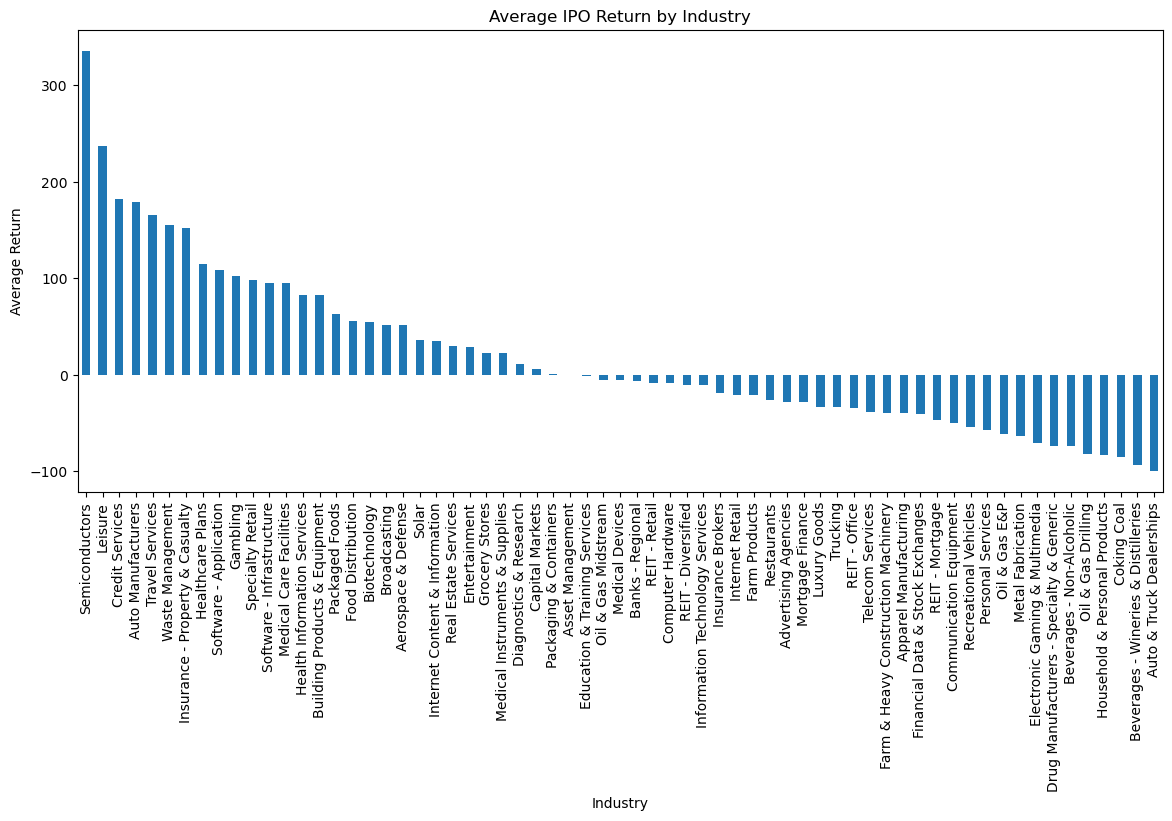

In [9]:
# plot each industries average return 
industry_returns.plot(kind='bar', figsize=(14,6))
plt.title('Average IPO Return by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Return')
plt.xticks(rotation=90)
plt.show()

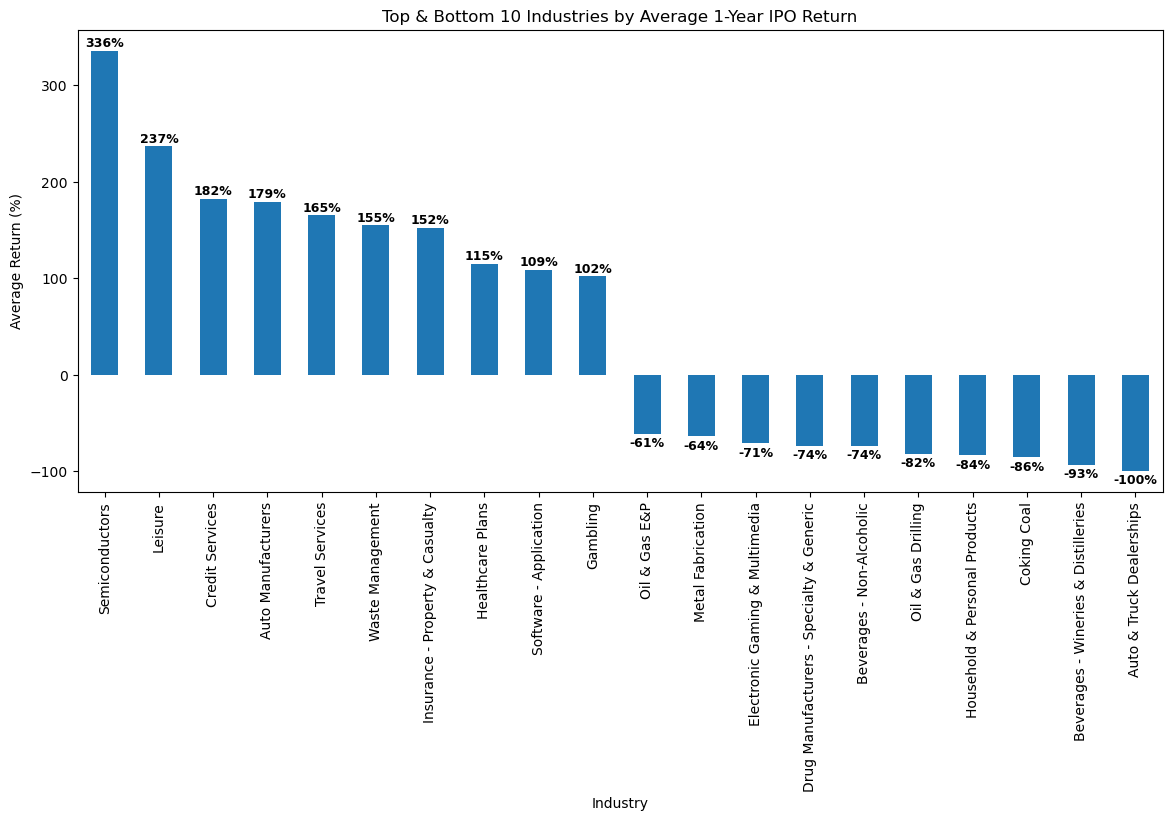

In [10]:
# Get top and bottom 5, with correct ordering
top_5 = industry_summary.sort_values('Average_Return', ascending=False).head(10)
bottom_5 = industry_summary.sort_values('Average_Return', ascending=True).head(10).sort_values('Average_Return', ascending=False)

# Combine
top_bottom = pd.concat([top_5, bottom_5])

# Plot
ax = top_bottom['Average_Return'].plot(kind='bar', figsize=(14,6))
plt.title('Top & Bottom 10 Industries by Average 1-Year IPO Return')
plt.xlabel('Industry')
plt.ylabel('Average Return (%)')
plt.xticks(rotation=90)

# Add data callouts
for i, val in enumerate(top_bottom['Average_Return']):
    ax.text(i, val + (1 if val >= 0 else -3), f"{val:.0f}%", 
            ha='center', va='bottom' if val >= 0 else 'top', fontsize=9, fontweight='bold')

# Display Results
plt.show()

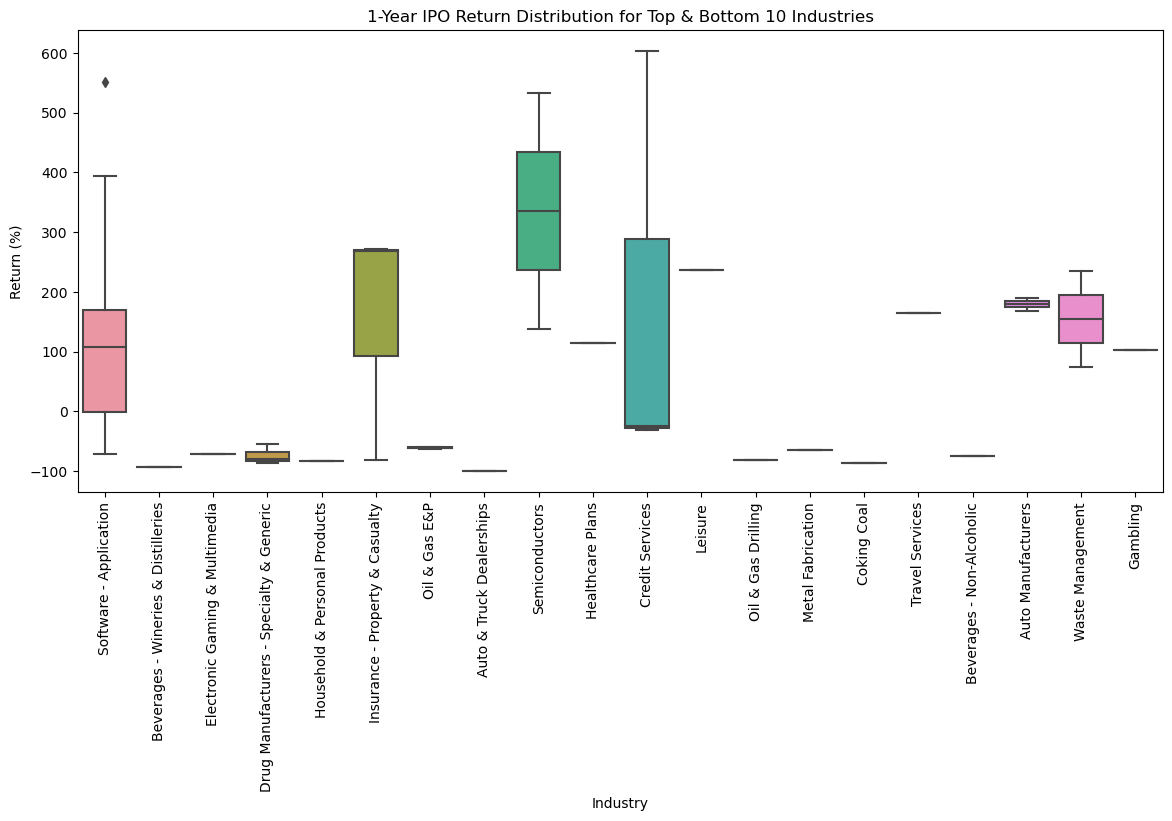

In [11]:
# Group by Industry and calculate average return
industry_avg = merged_with_financials_clean.groupby('Industry')['Return_1Y_pct'].mean().round(2)

# Get top 5 and bottom 5 industries
top_industries = industry_avg.sort_values(ascending=False).head(10).index
bottom_industries = industry_avg.sort_values(ascending=True).head(10).index
selected_industries = top_industries.tolist() + bottom_industries.tolist()

# Filter DataFrame
filtered_df = merged_with_financials_clean[
    merged_with_financials_clean["Industry"].isin(selected_industries)
].copy()

# Create box plot
plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=filtered_df, x="Industry", y="Return_1Y_pct")
plt.xticks(rotation=90)
plt.title("1-Year IPO Return Distribution for Top & Bottom 10 Industries")
plt.xlabel("Industry")
plt.ylabel("Return (%)")

# Display Results
plt.show()

In [12]:
# Group by industry and gather 'Return' values
industries = merged_with_financials_clean['Industry'].dropna().unique()
returns_list = []

for ind in industries:
    subset = merged_with_financials_clean[merged_with_financials_clean['Industry'] == ind]
    returns = subset['Return'].dropna()
    if len(returns) > 1:
        returns_list.append(returns)

# Run ANOVA F-test
from scipy import stats
F_statistic, p_value = stats.f_oneway(*returns_list)

print("F-statistic:", F_statistic)
print("p-value:", p_value)

F-statistic: 2.5008380661757124
p-value: 2.9207057405437358e-05


In [13]:
# Filter industries with at least a few companies (optional to avoid small groups)
industry_counts = merged_with_financials_clean['Industry'].value_counts()
valid_industries = industry_counts[industry_counts >= 3].index
filtered_anova = merged_with_financials_clean[merged_with_financials_clean['Industry'].isin(valid_industries)]

# Split returns by industry into separate lists
grouped_returns = [
    group['Return'].dropna().values
    for name, group in filtered_anova.groupby('Industry')
]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*grouped_returns)

# Report results
print("F-Statistic:", round(f_stat, 4))
print("P-Value:", round(p_value, 6))

# Conclusion
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis — at least one industry differs in average IPO return.")
else:
    print("Fail to reject the null — no significant difference in returns between industries.")

F-Statistic: 3.5053
P-Value: 1e-06
Reject the null hypothesis — at least one industry differs in average IPO return.


In [14]:
# Categorize companies by Market Cap size
def classify_market_cap(market_cap):
    if pd.isna(market_cap):
        return 'Unknown'
    elif market_cap < 300:
        return 'Small Cap'
    elif market_cap <= 2000:
        return 'Mid Cap'
    else:
        return 'Large Cap'

merged_with_financials_clean['Market Cap Size'] = merged_with_financials_clean['Market Cap'].apply(classify_market_cap)
merged_with_financials_clean.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct,Market Cap Size
0,2019-12-19,MNPR,Monopar Therapeutics Inc.,132.5,45.25,459.38,276.59,2019,Biotechnology,87.0,86.55,47.5,28.6,-34.34,-34.68,-64.15,-78.42,Small Cap
1,2019-12-13,OCFT,"OneConnect Financial Technology Co., Ltd.",100.0,6.13,-38.70,246.07,2019,Software - Application,98.5,156.80,153.9,206.9,-1.50,56.80,53.90,106.90,Small Cap
2,2019-11-08,CNSP,"CNS Pharmaceuticals, Inc.",342750.0,1.11,-71.75,3.27,2019,Biotechnology,328500.0,295500.00,207000.0,162000.0,-4.16,-13.79,-39.61,-52.74,Small Cap
3,2019-11-08,KRKR,36Kr Holdings Inc.,261.2,5.35,-63.38,10.54,2019,Advertising Agencies,199.6,180.00,73.0,59.8,-23.58,-31.09,-72.05,-77.11,Small Cap
4,2019-11-01,DUO,Fangdd Network Group Ltd.,2925.0,0.24,-98.24,11.63,2019,Real Estate Services,2925.0,2958.75,2520.0,1483.2,0.00,1.15,-13.85,-49.29,Small Cap


In [15]:
# Copy dataframe and create binary target
df_lr = merged_with_financials_clean.copy()
df_lr["Successful"] = (df_lr["Return_1Y_pct"] > 0).astype(int)

# One-hot encode Industry and Market Cap Size
df_lr = pd.get_dummies(df_lr, columns=["Industry", "Market Cap Size"], drop_first=True)

# Define features and target
X = df_lr.drop(columns=[
    "IPO Date", "Symbol", "Company Name", "Return_1Y_pct", "Successful", 
    "Current", "Year"
], errors="ignore")
y = df_lr["Successful"]

# Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target with filtered features

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluate results
y_pred = log_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Logistic Regression Accuracy (Industry + Market Cap Size):", round(accuracy, 3))

Logistic Regression Accuracy (Industry + Market Cap Size): 0.989


/Users/ethanlandin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


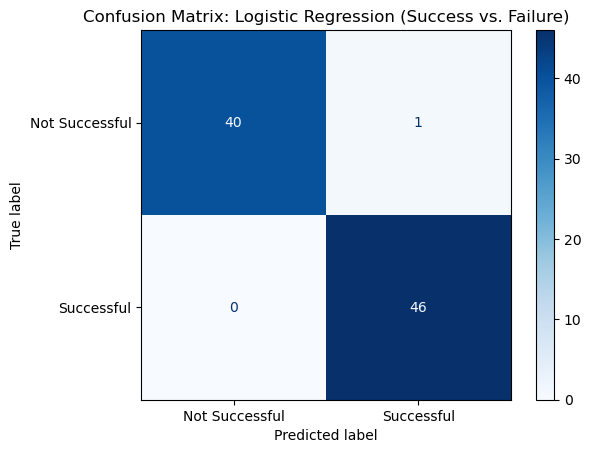

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Successful", "Successful"])

# Plot it
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression (Success vs. Failure)")
plt.show()

# Question 2

In [18]:
merged_with_financials_clean.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct,Market Cap Size
0,2019-12-19,MNPR,Monopar Therapeutics Inc.,132.5,45.25,459.38,276.59,2019,Biotechnology,87.0,86.55,47.5,28.6,-34.34,-34.68,-64.15,-78.42,Small Cap
1,2019-12-13,OCFT,"OneConnect Financial Technology Co., Ltd.",100.0,6.13,-38.70,246.07,2019,Software - Application,98.5,156.80,153.9,206.9,-1.50,56.80,53.90,106.90,Small Cap
2,2019-11-08,CNSP,"CNS Pharmaceuticals, Inc.",342750.0,1.11,-71.75,3.27,2019,Biotechnology,328500.0,295500.00,207000.0,162000.0,-4.16,-13.79,-39.61,-52.74,Small Cap
3,2019-11-08,KRKR,36Kr Holdings Inc.,261.2,5.35,-63.38,10.54,2019,Advertising Agencies,199.6,180.00,73.0,59.8,-23.58,-31.09,-72.05,-77.11,Small Cap
4,2019-11-01,DUO,Fangdd Network Group Ltd.,2925.0,0.24,-98.24,11.63,2019,Real Estate Services,2925.0,2958.75,2520.0,1483.2,0.00,1.15,-13.85,-49.29,Small Cap


In [19]:
merged_with_financials_clean = merged_with_financials_clean.copy()
merged_with_financials_clean['Market Cap Size'] = merged_with_financials_clean['Market Cap'].apply(classify_market_cap)

In [20]:
# Categorize companies by Market Cap size
def classify_market_cap(market_cap):
    if pd.isna(market_cap):
        return 'Unknown'
    elif market_cap < 300:
        return 'Small Cap'
    elif market_cap <= 2000:
        return 'Mid Cap'
    else:
        return 'Large Cap'

merged_with_financials_clean['Market Cap Size'] = merged_with_financials_clean['Market Cap'].apply(classify_market_cap)
merged_with_financials_clean.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct,Market Cap Size
0,2019-12-19,MNPR,Monopar Therapeutics Inc.,132.5,45.25,459.38,276.59,2019,Biotechnology,87.0,86.55,47.5,28.6,-34.34,-34.68,-64.15,-78.42,Small Cap
1,2019-12-13,OCFT,"OneConnect Financial Technology Co., Ltd.",100.0,6.13,-38.70,246.07,2019,Software - Application,98.5,156.80,153.9,206.9,-1.50,56.80,53.90,106.90,Small Cap
2,2019-11-08,CNSP,"CNS Pharmaceuticals, Inc.",342750.0,1.11,-71.75,3.27,2019,Biotechnology,328500.0,295500.00,207000.0,162000.0,-4.16,-13.79,-39.61,-52.74,Small Cap
3,2019-11-08,KRKR,36Kr Holdings Inc.,261.2,5.35,-63.38,10.54,2019,Advertising Agencies,199.6,180.00,73.0,59.8,-23.58,-31.09,-72.05,-77.11,Small Cap
4,2019-11-01,DUO,Fangdd Network Group Ltd.,2925.0,0.24,-98.24,11.63,2019,Real Estate Services,2925.0,2958.75,2520.0,1483.2,0.00,1.15,-13.85,-49.29,Small Cap


## Univariate Q2

In [22]:
# Summary stats for 1-year IPO return
print("Summary statistics for 1-Year IPO Return:")
print(merged_with_financials_clean['Return_1Y_pct'].describe())

Summary statistics for 1-Year IPO Return:
count    291.000000
mean      41.723608
std      125.257311
min      -99.800000
25%      -40.605000
50%        5.190000
75%       84.000000
max      620.000000
Name: Return_1Y_pct, dtype: float64


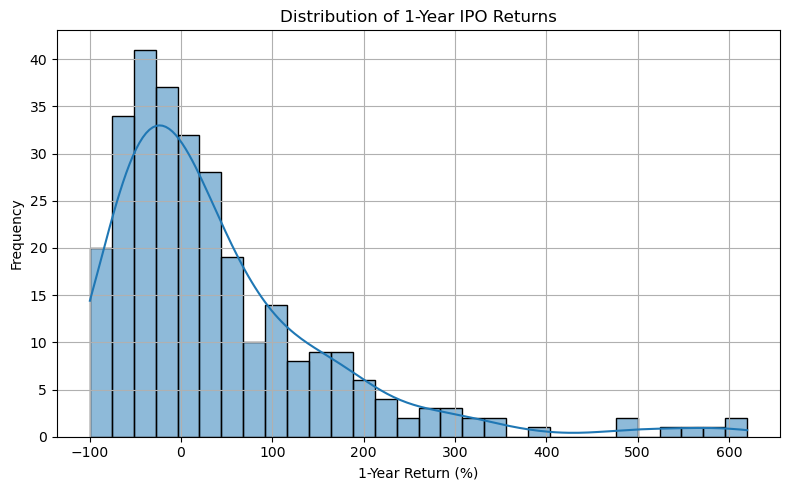

In [23]:
# Drop missing returns
returns_1y = merged_with_financials_clean['Return_1Y_pct'].dropna()

# Plot histogram with KDE
plt.figure(figsize=(8,5))
sns.histplot(returns_1y, bins=30, kde=True)
plt.title('Distribution of 1-Year IPO Returns')
plt.xlabel('1-Year Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## Bivariate Q2

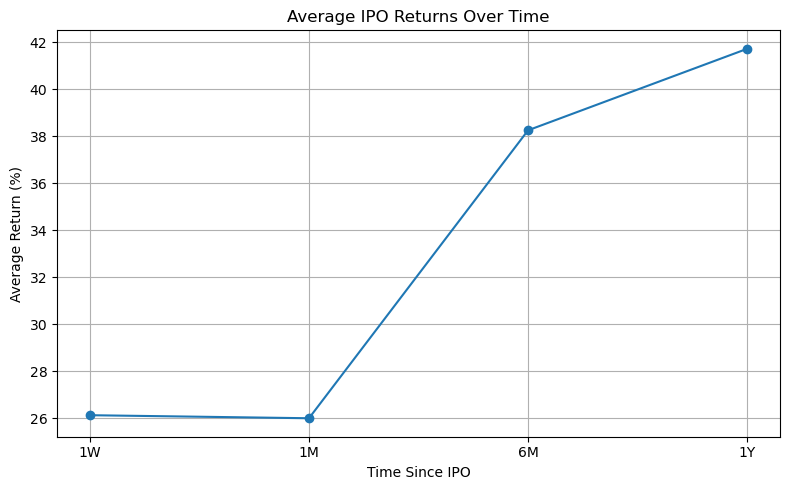

In [25]:
# Average returns across time points
mean_returns = {
    '1W': merged_with_financials_clean['Return_1W_pct'].mean(),
    '1M': merged_with_financials_clean['Return_1M_pct'].mean(),
    '6M': merged_with_financials_clean['Return_6M_pct'].mean(),
    '1Y': merged_with_financials_clean['Return_1Y_pct'].mean()
}

# Plot
plt.figure(figsize=(8,5))
plt.plot(list(mean_returns.keys()), list(mean_returns.values()), marker='o')
plt.title('Average IPO Returns Over Time')
plt.xlabel('Time Since IPO')
plt.ylabel('Average Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

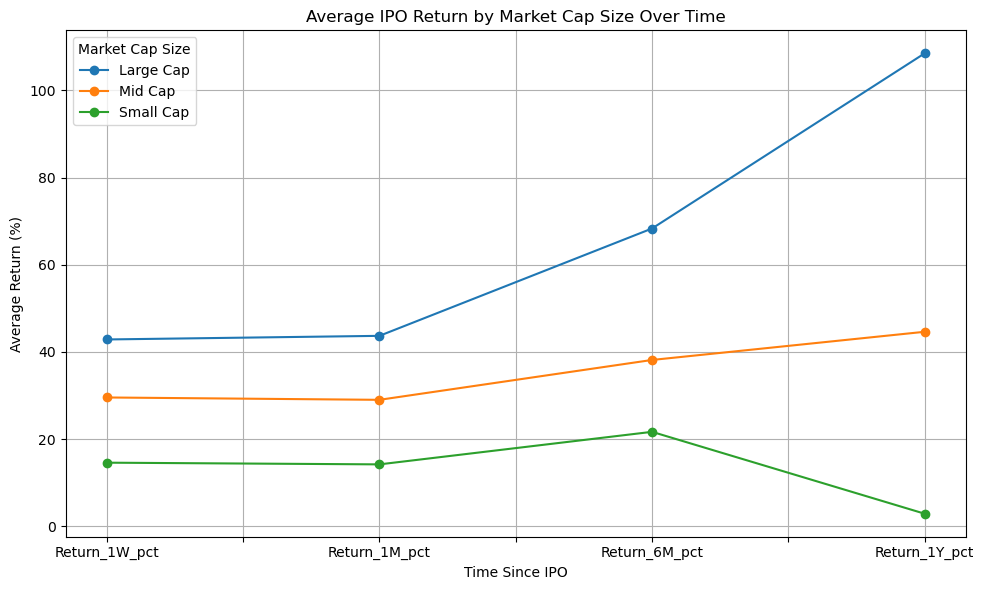

In [26]:
# Group by Market Cap Size and compute average return for each period
capsize_returns = merged_with_financials_clean.groupby('Market Cap Size')[
    ['Return_1W_pct', 'Return_1M_pct', 'Return_6M_pct', 'Return_1Y_pct']
].mean().round(2)

# Transpose for better plotting
capsize_returns_T = capsize_returns.T

# Plot data
capsize_returns_T.plot(kind='line', marker='o', figsize=(10,6))
plt.title('Average IPO Return by Market Cap Size Over Time')
plt.xlabel('Time Since IPO')
plt.ylabel('Average Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Hypothesis test for Q2

In [28]:
# Drop rows with missing values
paired_data = merged_with_financials_clean.dropna(subset=['Return_6M_pct', 'Return_1Y_pct'])

# Extract paired samples
returns_6m = paired_data['Return_6M_pct']
returns_1y = paired_data['Return_1Y_pct']

# Paired t-test
t_stat, p_value = stats.ttest_rel(returns_6m, returns_1y)

# Report
print("Paired t-test Results (6-Months vs 1-Year):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Decision
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis — there is a significant difference between 6M and 1Y returns.")
else:
    print("Result: Fail to reject the null — no significant difference between 6M and 1Y returns.")

Paired t-test Results (6-Months vs 1-Year):
T-statistic: -0.6487
P-value: 0.5171
Result: Fail to reject the null — no significant difference between 6M and 1Y returns.


In [29]:
# Drop rows with missing values
paired_data = merged_with_financials_clean.dropna(subset=['Return_1M_pct', 'Return_1Y_pct'])

# Extract paired samples
returns_1m = paired_data['Return_1M_pct']
returns_1y = paired_data['Return_1Y_pct']

# Paired t-test
t_stat, p_value = stats.ttest_rel(returns_1m, returns_1y)

# Report
print("Paired t-test Results (1-Month vs 1-Year):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Decision
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis — there is a significant difference between 1M and 1Y returns.")
else:
    print("Result: Fail to reject the null — no significant difference between 1M and 1Y returns.")

Paired t-test Results (1-Month vs 1-Year):
T-statistic: -2.3008
P-value: 0.0221
Result: Reject the null hypothesis — there is a significant difference between 1M and 1Y returns.


## Machine Learning

In [31]:
# create df for q_2 machine learning 
df_q2 = merged_with_financials_clean.dropna(subset=["Return_6M_pct", "Return_1W_pct", "Return_1M_pct"])
X2 = df_q2[["Return_1W_pct", "Return_1M_pct"]]
y2 = df_q2["Return_6M_pct"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

model_q2 = LinearRegression()
model_q2.fit(X2_train, y2_train)
r2 = r2_score(y2_test, model_q2.predict(X2_test))

print("Q2 Linear Regression R²:", round(r2, 3))

Q2 Linear Regression R²: 0.321


Q2 Decision Tree Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.82      0.87      0.85        47

    accuracy                           0.83        88
   macro avg       0.83      0.83      0.83        88
weighted avg       0.83      0.83      0.83        88



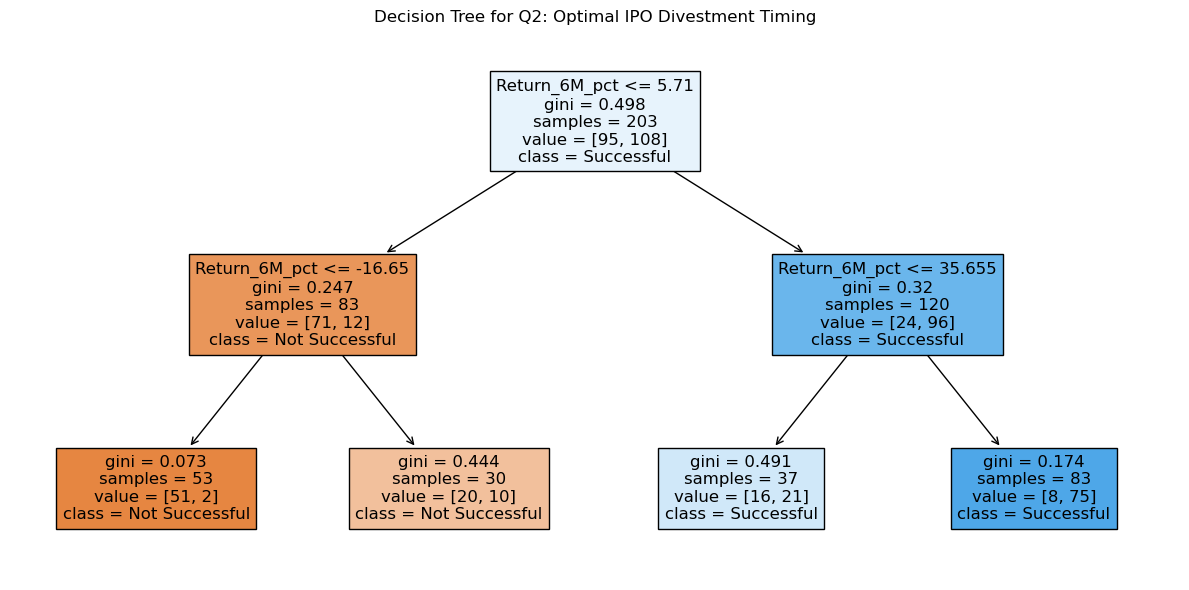

In [32]:
# Define success label based on 1Y return
merged_with_financials_clean['Success_Q2'] = (merged_with_financials_clean['Return_1Y_pct'] > 0).astype(int)

# Select predictors and target
features_q2 = ['Return_1W_pct', 'Return_1M_pct', 'Return_6M_pct']
X_q2 = merged_with_financials_clean[features_q2].dropna()
y_q2 = merged_with_financials_clean.loc[X_q2.index, 'Success_Q2']

# Train/test split
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(
    X_q2, y_q2, test_size=0.3, stratify=y_q2, random_state=42
)

# Fit decision tree model
tree_model_q2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_model_q2.fit(X_train_q2, y_train_q2)

# Evaluate model
y_pred_q2 = tree_model_q2.predict(X_test_q2)
acc = accuracy_score(y_test_q2, y_pred_q2)
print("Q2 Decision Tree Accuracy:", round(acc, 3))
print(classification_report(y_test_q2, y_pred_q2))

# Visualize decision tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model_q2, feature_names=features_q2, class_names=["Not Successful", "Successful"], filled=True)
plt.title("Decision Tree for Q2: Optimal IPO Divestment Timing")
plt.tight_layout()
plt.show()

## Additional Visual

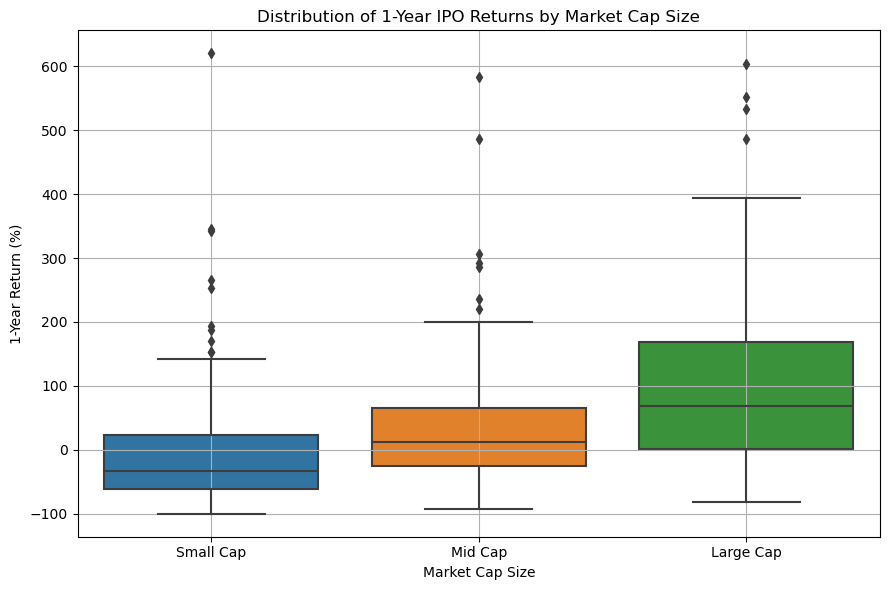

In [34]:
# plot ipo return by market cap size, box plots
plt.figure(figsize=(9,6))
sns.boxplot(x='Market Cap Size', y='Return_1Y_pct', data=merged_with_financials_clean)
plt.title('Distribution of 1-Year IPO Returns by Market Cap Size')
plt.xlabel('Market Cap Size')
plt.ylabel('1-Year Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

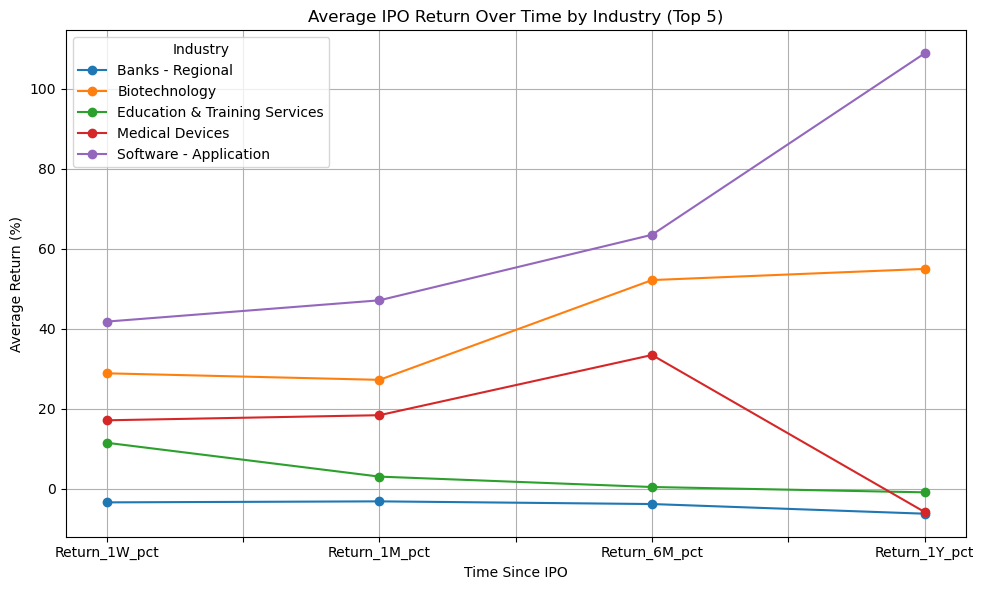

In [35]:
# Pick top 5 most frequent industries
top_industries = merged_with_financials_clean['Industry'].value_counts().head(5).index

# Filter
industry_subset = merged_with_financials_clean[merged_with_financials_clean['Industry'].isin(top_industries)]

# Group + average
industry_returns = industry_subset.groupby('Industry')[
    ['Return_1W_pct', 'Return_1M_pct', 'Return_6M_pct', 'Return_1Y_pct']
].mean().T

# Plot linear return 
industry_returns.plot(figsize=(10,6), marker='o')
plt.title('Average IPO Return Over Time by Industry (Top 5)')
plt.ylabel('Average Return (%)')
plt.xlabel('Time Since IPO')
plt.grid(True)
plt.tight_layout()
plt.show()

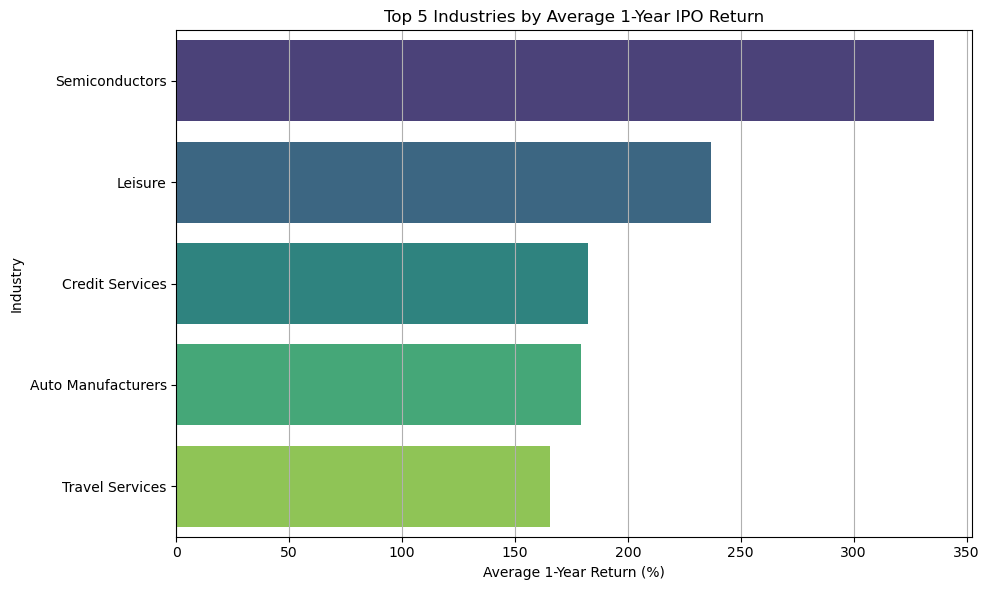

In [36]:
# Compute average 1Y return by industry
avg_return_by_industry = (
    merged_with_financials_clean
    .groupby('Industry')['Return_1Y_pct']
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

# Select top 5 industries
top5_industries = avg_return_by_industry.head(5)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x=top5_industries.values,
    y=top5_industries.index,
    palette='viridis'
)
plt.title('Top 5 Industries by Average 1-Year IPO Return')
plt.xlabel('Average 1-Year Return (%)')
plt.ylabel('Industry')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# Question 3

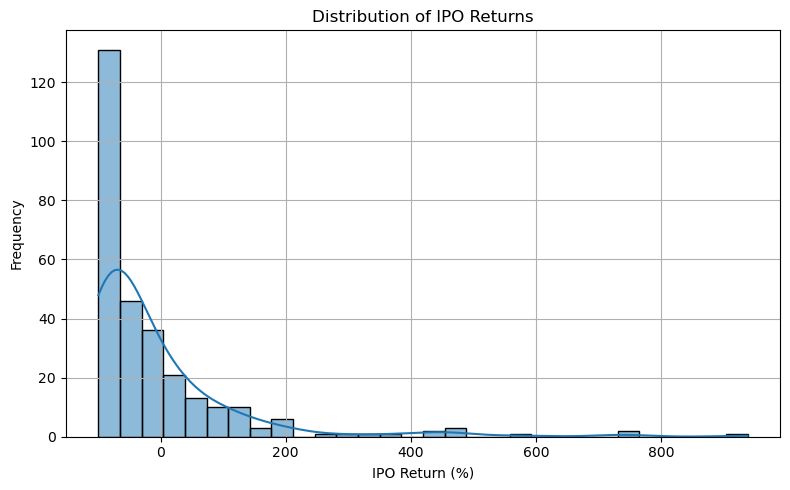

In [38]:
# Univariate analysis for Question 3: Distribution of IPO returns
plt.figure(figsize=(8, 5))
sns.histplot(merged_with_financials_clean['Return'], bins=30, kde=True)
plt.title('Distribution of IPO Returns')
plt.xlabel('IPO Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

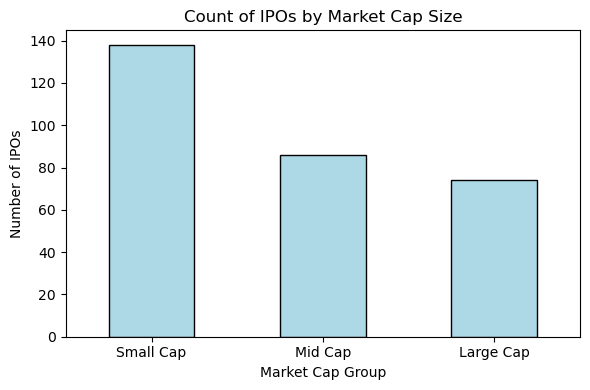

In [39]:
# Univariate analysis: Distribution of Market Cap Sizes
market_cap_counts = merged_with_financials_clean['Market Cap Size'].value_counts()

plt.figure(figsize=(6, 4))
market_cap_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Count of IPOs by Market Cap Size')
plt.xlabel('Market Cap Group')
plt.ylabel('Number of IPOs')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# Sort the DataFrame by Market Cap in descending order and select the top 5 companies
top_5_companies = merged_with_financials_clean.sort_values(by='Market Cap', ascending=False).head(5)

# Display the result
print(top_5_companies[['Company Name', 'Symbol', 'Market Cap', 'Return']])


                   Company Name Symbol  Market Cap  Return
210  Palantir Technologies Inc.   PLTR    292530.0     NaN
132     Uber Technologies, Inc.   UBER    178640.0   90.27
122  CrowdStrike Holdings, Inc.   CRWD    109920.0     NaN
175              DoorDash, Inc.   DASH     87040.0  100.89
173                Airbnb, Inc.   ABNB     77080.0   85.07


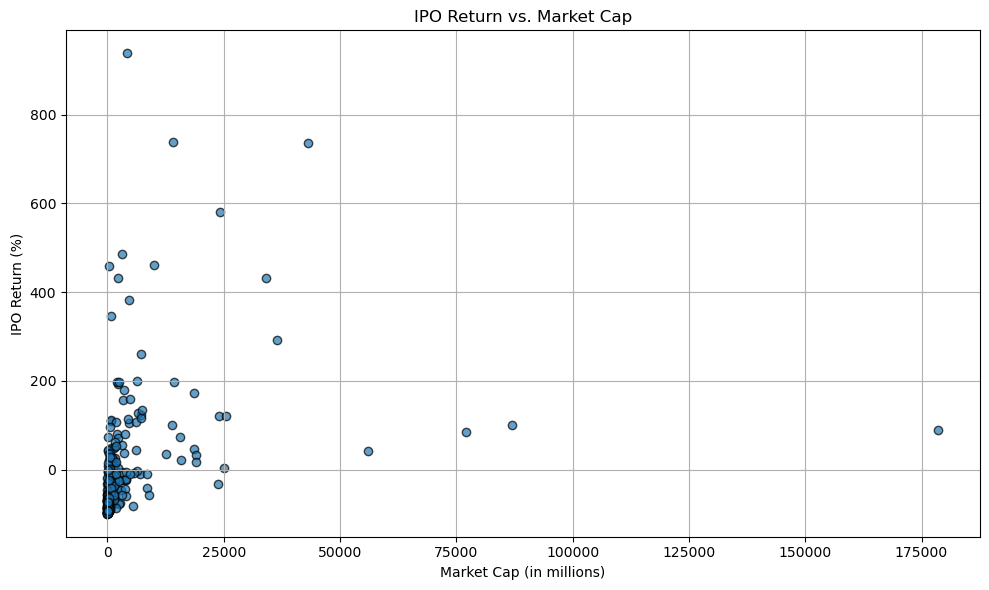

In [41]:
# Scatter plot of IPO Return vs. Market Cap
plt.figure(figsize=(10, 6))
plt.scatter(
    merged_with_financials_clean["Market Cap"],
    merged_with_financials_clean["Return"],
    alpha=0.7,
    edgecolors='k'
)

plt.title("IPO Return vs. Market Cap")
plt.xlabel("Market Cap (in millions)")
plt.ylabel("IPO Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

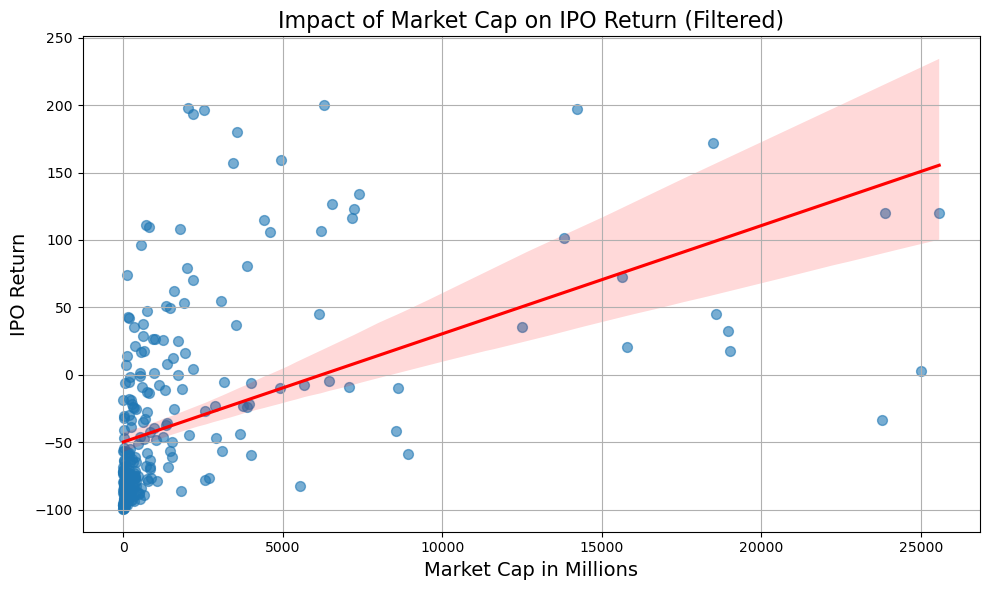

In [42]:
# Remove outliers: Market Cap > 100,000 or Return > 120000
filtered_df = merged_with_financials_clean[
    (merged_with_financials_clean['Market Cap'] <= 50000) &
    (merged_with_financials_clean['Return'] <= 250)
]

# Scatterplot with Regression Line (after filtering)
plt.figure(figsize=(10,6))
sns.regplot(
    x='Market Cap', 
    y='Return', 
    data=filtered_df, 
    scatter_kws={'s':50, 'alpha':0.6}, 
    line_kws={'color':'red'}
)

plt.title('Impact of Market Cap on IPO Return (Filtered)', fontsize=16)
plt.xlabel('Market Cap in Millions', fontsize=14)
plt.ylabel('IPO Return', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# Features and Target
X = filtered_df[['Market Cap']]
y = filtered_df['Return']

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 4032.0979550674006
R-squared: 0.11128115769349878


In [44]:
# Group market caps
small_cap = filtered_df[filtered_df['Market Cap'] < 300]['Return']
large_cap = filtered_df[filtered_df['Market Cap'] > 2000]['Return']

# t-test
stats.ttest_ind(small_cap, large_cap, equal_var=False)

TtestResult(statistic=-10.081060153182538, pvalue=1.54634021820385e-14, df=60.09297717786782)

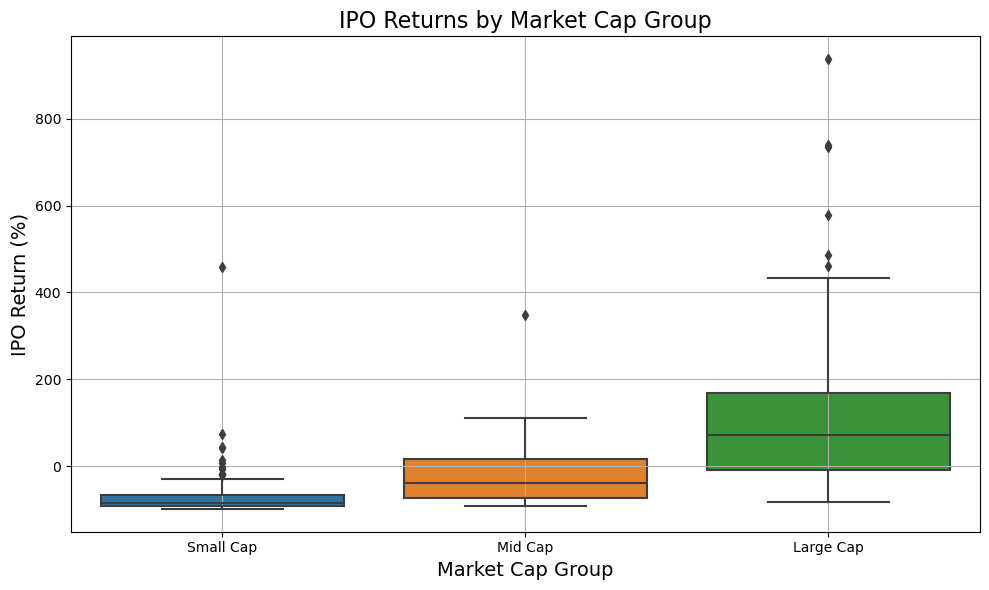

In [45]:
# Filter out rows with missing or unknown Market Cap Size or Return
subset = merged_with_financials_clean[
    merged_with_financials_clean["Market Cap Size"].isin(['Small Cap', 'Mid Cap', 'Large Cap'])
].copy()
subset = subset.dropna(subset=["Return"])

# Boxplot of IPO Return by Market Cap Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Market Cap Size', y='Return', data=subset, order=['Small Cap', 'Mid Cap', 'Large Cap'])

plt.title('IPO Returns by Market Cap Group', fontsize=16)
plt.xlabel('Market Cap Group', fontsize=14)
plt.ylabel('IPO Return (%)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Define variables
X = merged_with_financials_clean[['Market Cap']]
y = merged_with_financials_clean['Return_1Y_pct']

# Drop NAs
valid_data = merged_with_financials_clean.dropna(subset=['Market Cap', 'Return_1Y_pct'])
model = LinearRegression().fit(valid_data[['Market Cap']], valid_data['Return_1Y_pct'])

print("R²:", model.score(valid_data[['Market Cap']], valid_data['Return_1Y_pct']))

R²: 0.023551268431902472


## Machine Learning

Q3 Linear Regression R²: 0.288
Q3 Linear Regression RMSE: 107.865


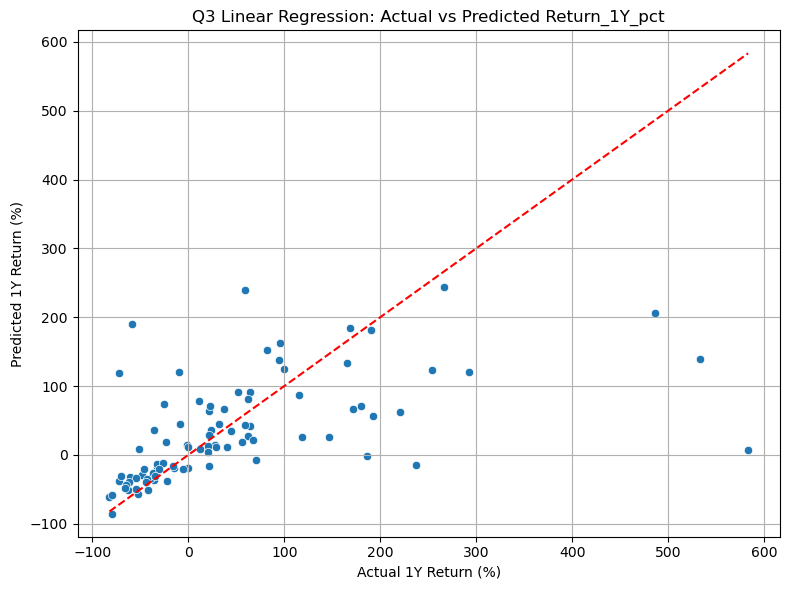

In [48]:
# Select features and target
features_q3 = ['Market Cap', 'Return_1W_pct', 'Return_1M_pct', 'Return_6M_pct']
X_q3 = merged_with_financials_clean[features_q3].dropna()
y_q3 = merged_with_financials_clean.loc[X_q3.index, 'Return_1Y_pct']

# Train/test split
X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(
    X_q3, y_q3, test_size=0.3, random_state=42
)

# Fit linear regression model
lin_model_q3 = LinearRegression()
lin_model_q3.fit(X_train_q3, y_train_q3)

# Predict and evaluate
y_pred_q3 = lin_model_q3.predict(X_test_q3)
r2 = r2_score(y_test_q3, y_pred_q3)
rmse = mean_squared_error(y_test_q3, y_pred_q3, squared=False)

print("Q3 Linear Regression R²:", round(r2, 3))
print("Q3 Linear Regression RMSE:", round(rmse, 3))

# Visualize predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_q3, y=y_pred_q3)
plt.plot([y_test_q3.min(), y_test_q3.max()], [y_test_q3.min(), y_test_q3.max()], 'r--')
plt.xlabel("Actual 1Y Return (%)")
plt.ylabel("Predicted 1Y Return (%)")
plt.title("Q3 Linear Regression: Actual vs Predicted Return_1Y_pct")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Saves
Additionally data needed for Data Dictionary

In [50]:
merged_with_financials_clean.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Market Cap,Year,Industry,Price_1W,Price_1M,Price_6M,Price_1Y,Return_1W_pct,Return_1M_pct,Return_6M_pct,Return_1Y_pct,Market Cap Size,Success_Q2
0,2019-12-19,MNPR,Monopar Therapeutics Inc.,132.5,45.25,459.38,276.59,2019,Biotechnology,87.0,86.55,47.5,28.6,-34.34,-34.68,-64.15,-78.42,Small Cap,0
1,2019-12-13,OCFT,"OneConnect Financial Technology Co., Ltd.",100.0,6.13,-38.70,246.07,2019,Software - Application,98.5,156.80,153.9,206.9,-1.50,56.80,53.90,106.90,Small Cap,1
2,2019-11-08,CNSP,"CNS Pharmaceuticals, Inc.",342750.0,1.11,-71.75,3.27,2019,Biotechnology,328500.0,295500.00,207000.0,162000.0,-4.16,-13.79,-39.61,-52.74,Small Cap,0
3,2019-11-08,KRKR,36Kr Holdings Inc.,261.2,5.35,-63.38,10.54,2019,Advertising Agencies,199.6,180.00,73.0,59.8,-23.58,-31.09,-72.05,-77.11,Small Cap,0
4,2019-11-01,DUO,Fangdd Network Group Ltd.,2925.0,0.24,-98.24,11.63,2019,Real Estate Services,2925.0,2958.75,2520.0,1483.2,0.00,1.15,-13.85,-49.29,Small Cap,0


In [51]:
merged_with_financials_clean.dtypes

IPO Date            object
Symbol              object
Company Name        object
IPO Price          float64
Current            float64
Return             float64
Market Cap         float64
Year                 int64
Industry            object
Price_1W           float64
Price_1M           float64
Price_6M           float64
Price_1Y           float64
Return_1W_pct      float64
Return_1M_pct      float64
Return_6M_pct      float64
Return_1Y_pct      float64
Market Cap Size     object
Success_Q2           int64
dtype: object

In [52]:
# Save to CSV if needed
merged_with_financials_clean.to_csv("Project_Data_Final.csv", index=False)